<a href="https://colab.research.google.com/github/drwbkr1/Grad504-Hierarchical-Cluster-Project/blob/main/GRAD504_HC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
plants= ("/content/drive/MyDrive/Colab Notebooks/datasets/plants.data")

'''After discovering the correct encoding, I noticed the loader didn't like the
different number of datapoints in each line. So now I'm one-hot encoding the
dataset right out of the box

We're going to split the plants from the states, then one-hot encode the states.
We'll add the plant's back to the dataframe after the one-hot encoding.'''

plants_list= []
states_list= []

with open(plants, encoding='ISO-8859-1') as file:
  for line in file:
    items= line.strip().split(",") #turn each line into a list
    plants_list.append(items[0])            #reorganize the list into respective variables
    states_list.append(items[1:])

#states_list[:10]


In [17]:
mlb= MultiLabelBinarizer()

states_ohe= mlb.fit_transform(states_list)

df= pd.DataFrame(states_ohe, columns= mlb.classes_, index= plants_list)
df= df.rename(columns= {"index" : "Flowers"})
#df.head(10)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
df.shape

(34781, 70)

In [ ]:
'''Oh boy, 34000 flower types in 70 regions. That's 2.38 million combinations.
We have our work cut out for us'''

In [62]:
from hdbscan.hdbscan_ import HDBSCAN
import matplotlib.pyplot as plt

clusterer= HDBSCAN(min_cluster_size= 1000,
                   min_samples=2,
                   metric= 'jaccard',
                   core_dist_n_jobs= -3
                   )

clusterer.fit(df)

#plt.figure(figsize=(10, 5))
#clusterer.condensed_tree_.plot()
#clusterer.single_linkage_tree_.plot()
#plt.title("HDBSCAN Condensed Tree (with selected clusters)")
#plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN(core_dist_n_jobs=-3, metric='jaccard', min_cluster_size=1000,
        min_samples=2)

/usr/local/lib/python3.11/dist-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


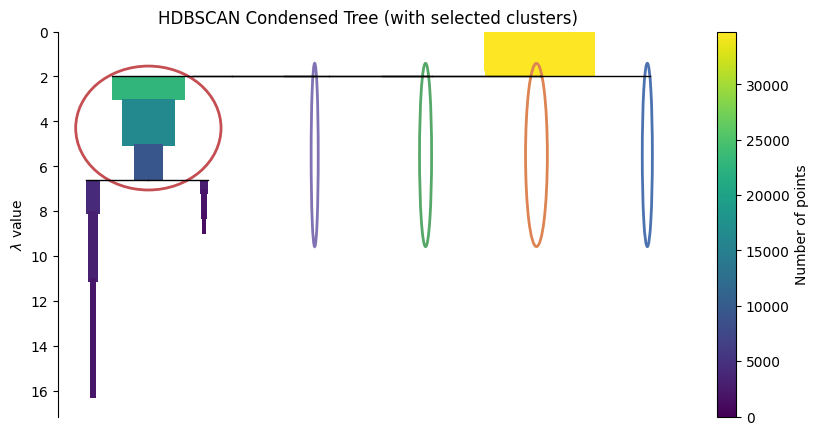

In [63]:
plt.figure(figsize=(10, 5))
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8),
                               max_rectangles_per_icicle= 3,
                               )
#clusterer.single_linkage_tree_.plot()
plt.title("HDBSCAN Condensed Tree (with selected clusters)")
plt.show()

In [64]:
labels= clusterer.labels_

unique_labels, count= np.unique(labels, return_counts= True)
for label, cnt in zip(unique_labels, count):
  name= (f"Cluster {label}") if label != -1 else "Noise"
  print(f"{name}: {cnt} points")

Noise: 3975 points
Cluster 0: 1582 points
Cluster 1: 3421 points
Cluster 2: 1896 points
Cluster 3: 22795 points
Cluster 4: 1112 points


Up next:
- discover what these clusters are representing
- Try learning counts per state in each cluster
- Try overlaying on map

In [94]:
cluster_id = 3   # e.g. 0, 1, 2, … or -1 for noise

# 2️⃣ Select only the rows (flowers) in that cluster
mask     = (labels == cluster_id)
df_clust = df.loc[mask]

# 3️⃣ Sum up the 1’s in each state-column
state_counts = df_clust.sum(axis=0)   # Series indexed by state code

# 4️⃣ Sort descending and print
state_counts_sorted = state_counts.sort_values(ascending=False)

print(f"State counts for Cluster {cluster_id}:")
print(state_counts_sorted[:60])
flower_counts = df.loc[mask].sum(axis=1)  # Series indexed by flower name

# Show the 10 flowers with the highest state-counts
print(flower_counts.nlargest(len(flower_counts)).mean())


State counts for Cluster 3:
ca    8152
tx    7306
or    6770
nm    6245
az    6240
fl    5943
ga    5868
nc    5846
ut    5723
al    5617
ny    5569
va    5546
nv    5529
wa    5483
sc    5384
pa    5327
co    5309
la    5092
il    5076
id    5030
md    4995
on    4943
tn    4852
bc    4802
ms    4783
ma    4770
mt    4737
nj    4711
oh    4696
wy    4648
mi    4634
ok    4625
mo    4573
ar    4560
ky    4503
in    4408
ct    4305
wi    4249
qc    4167
wv    4020
me    3891
mn    3881
ks    3829
vt    3652
ia    3603
de    3598
nh    3594
ab    3368
ri    3268
ne    3255
pr    3168
sd    3164
dc    3048
mb    2993
nb    2834
ns    2812
sk    2803
ak    2710
nd    2656
nf    2159
dtype: int64
12.626847992980917


In [103]:
cluster_series = pd.Series(labels, index=df.index, name="cluster")

# 2️⃣ Lookup the cluster of “sabal palmetto”
flower_name = "sabal palmetto"
cluster_id   = cluster_series.loc[flower_name]

print(f"Flower '{flower_name}' is in Cluster {cluster_id}")
sp= df.loc[flower_name].sort_values(ascending=False)
print(sp.head(10))


Flower 'sabal palmetto' is in Cluster 3
al    1
nc    1
la    1
ms    1
ga    1
fl    1
sc    1
bc    0
ar    0
ak    0
Name: sabal palmetto, dtype: int64
